In [1]:
# RNN with multiplicative gain in supplementary fig 2.e

import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.gain4 import Gain4
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerPmd2 import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g0_bound = [0.5, 1.25]
gSlope_bound = [0,0]


# Generate a batch of trials with linear gain

In [3]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound, noise = 0.25)

In [4]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 2,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [0, 1],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0,
 'g0_bound': [0.5, 1.25],
 'gSlope_bound': [0, 0]}

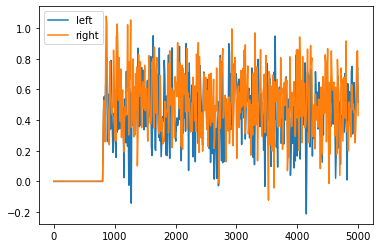

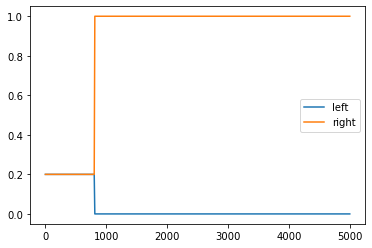

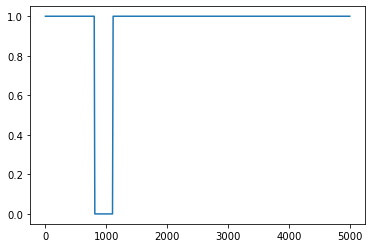

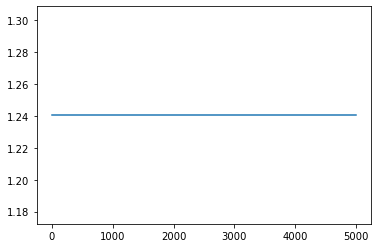

[1.24056929 0.        ]
{'coherence': 0.4663412368298394, 'noise': 0.25, 'accumulation_mask': 300, 'target_onset': 304, 'checker_onset': 505, 'g0_bound': [0.5, 1.25], 'gSlope_bound': [0, 0]}


In [5]:
[x, y, mask, allParams, g, gainParams] = task.get_trial_batch()

trialNum = 1
# x[1]: left tartet evidence
# x[2]: right target evidence
trialIn = x[trialNum,:,:]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
# plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])
# plot gain
plt.figure()
plt.plot(time, g[trialNum,:,:])
plt.show()
print(gainParams[trialNum,:])
print(allParams[trialNum])

# Set Network params

In [6]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [7]:
try:
    model.destruct()
except:
    pass

model = Gain4(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [8]:
# check model
# vars(model)

# Set Training params & Train

In [9]:
trials = 50000
train_params = {}
train_params['save_weights_path'] =  "./weights/checkerPmdGain4Multiply"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [10]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./losses/checkerPmdGain4Multiply.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.173584
Iter 1000, Minibatch Loss= 0.142112
Iter 1500, Minibatch Loss= 0.123159
Iter 2000, Minibatch Loss= 0.110030
Iter 2500, Minibatch Loss= 0.089938
Iter 3000, Minibatch Loss= 0.086415
Iter 3500, Minibatch Loss= 0.081926
Iter 4000, Minibatch Loss= 0.094816
Iter 4500, Minibatch Loss= 0.080268
Iter 5000, Minibatch Loss= 0.066743
Iter 5500, Minibatch Loss= 0.076749
Iter 6000, Minibatch Loss= 0.073761
Iter 6500, Minibatch Loss= 0.074362
Iter 7000, Minibatch Loss= 0.062111
Iter 7500, Minibatch Loss= 0.060429
Iter 8000, Minibatch Loss= 0.057522
Iter 8500, Minibatch Loss= 0.058744
Iter 9000, Minibatch Loss= 0.050501
Iter 9500, Minibatch Loss= 0.054108
Iter 10000, Minibatch Loss= 0.057624
Iter 10500, Minibatch Loss= 0.052788
Iter 11000, Minibatch Loss= 0.048555
Iter 11500, Minibatch Loss= 0.048730
Iter 12000, Minibatch Loss= 0.046322
Iter 12500, Minibatch Loss= 0.043451
I

Text(0.5, 1.0, 'Loss During Training')

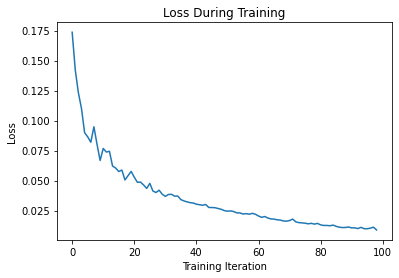

In [11]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

# Test 5000 trials

In [12]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)
decision = np.zeros(trials)
rt = np.zeros(trials)
g0 = np.zeros(trials)
gSlope = np.zeros(trials)

In [13]:
for b in tqdm(range(batches)):
    [x, y, mask, params, g, gainParams] = task.get_trial_batch()
    outputs, states, inputs = model.test(x,g)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 
        g0[index] = gainParams[i][0]
        gSlope[index] = gainParams[i][1]

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


/home/tianwang/anaconda3/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


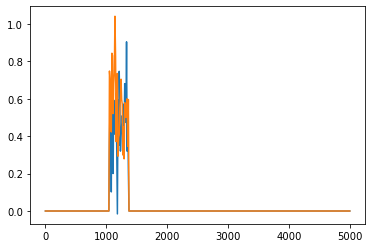

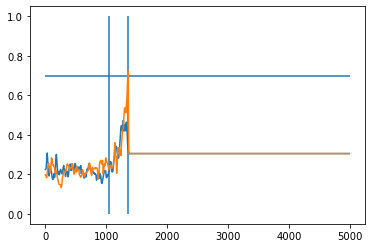

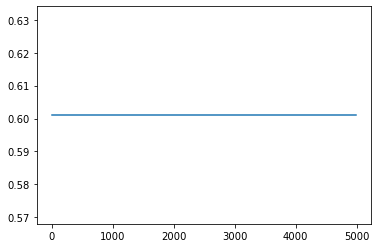

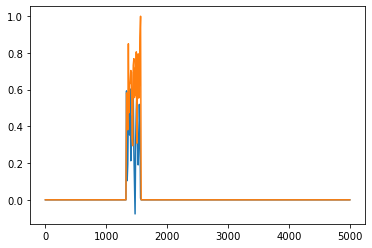

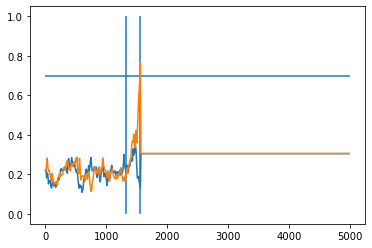

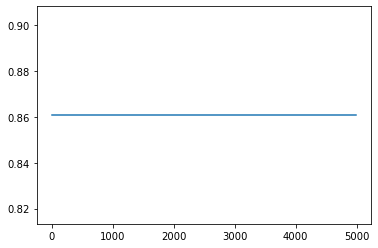

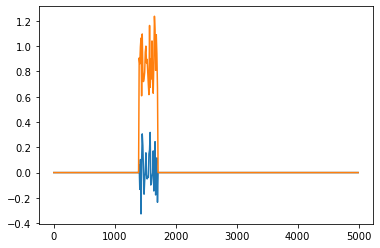

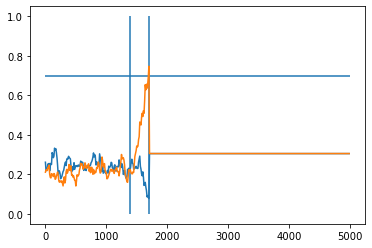

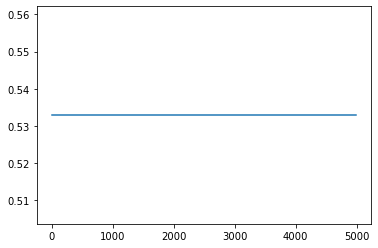

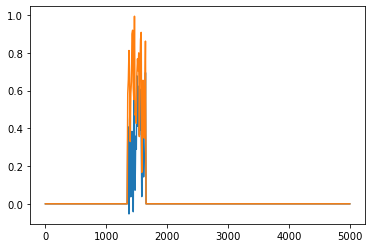

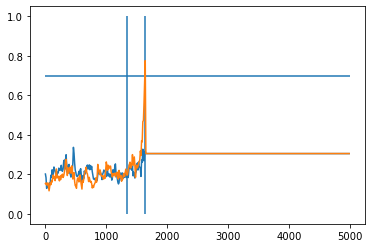

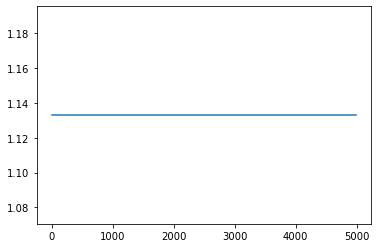

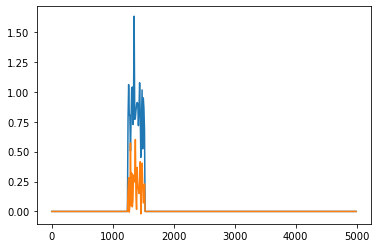

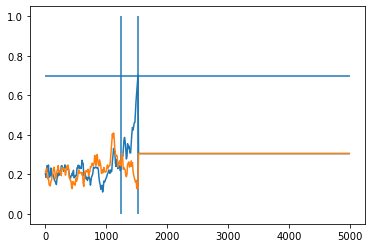

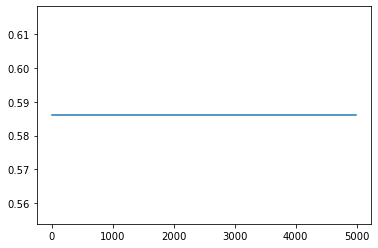

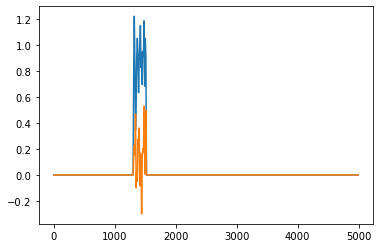

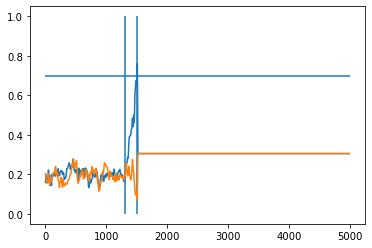

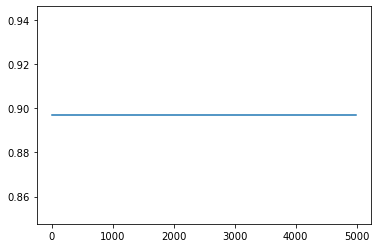

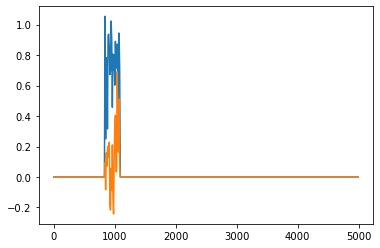

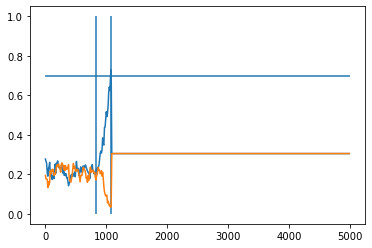

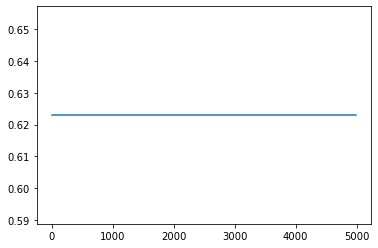

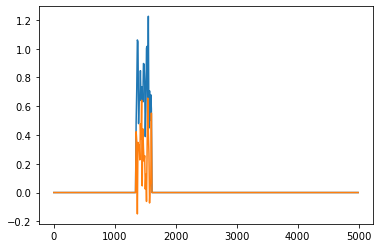

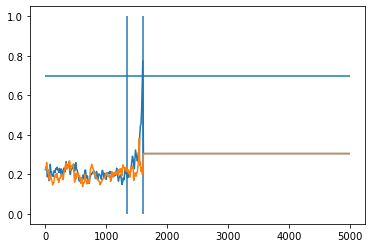

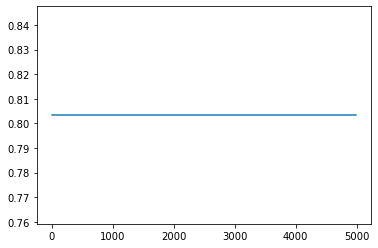

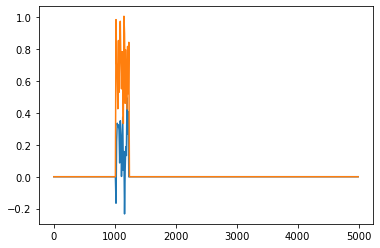

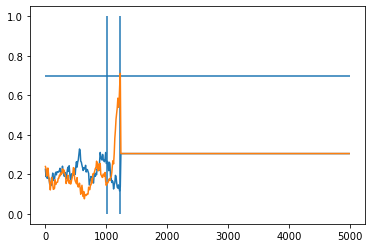

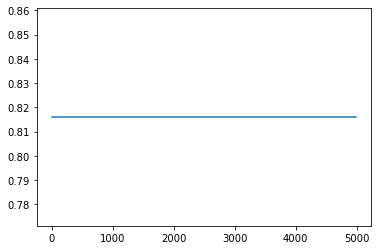

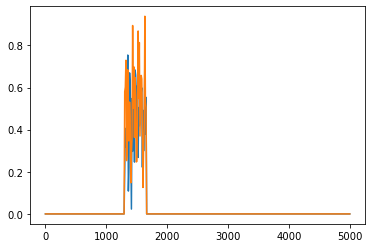

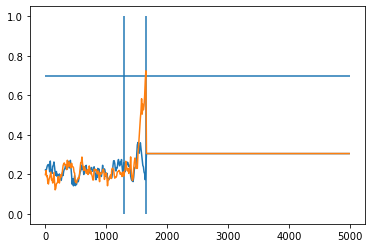

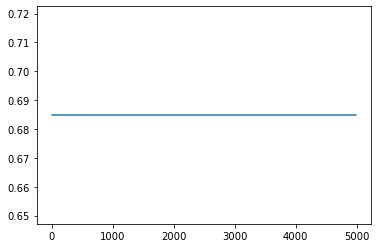

In [14]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10,20):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])

    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)
    plt.figure()
    plt.plot(np.arange(0, T, 10), g[i, :, :])

In [15]:
correct_side = (coherence > 0.5)
correct_side = 1 - 1*correct_side

checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : 2*coherence - 1,
                           'coherence_bin' : np.round(2*coherence - 1, 1),
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                          'g0' : g0,
                          'gSlope' : gSlope})

checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))




Overall Accuracy: 0.924
Negative RT trials ratio: 0.0016


In [16]:
checker_df

,trial,coherence,coherence_bin,correct_side,target_onset,checker_onset,decision,decision_time,correct_decision,g0,gSlope
0,0,0.043788,0.0,0,318.0,629.0,1.0,793.0,0,0.518222,0.0
1,1,0.694924,0.7,0,261.0,853.0,0.0,216.0,1,1.167339,0.0
2,2,0.427277,0.4,0,463.0,930.0,0.0,107.0,1,1.225218,0.0
3,3,-0.262083,-0.3,1,299.0,979.0,1.0,152.0,1,1.231279,0.0
4,4,-0.672198,-0.7,1,317.0,665.0,1.0,318.0,1,0.731852,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,-0.703329,-0.7,1,307.0,862.0,1.0,161.0,1,1.167100,0.0
4996,4996,-0.791403,-0.8,1,488.0,579.0,1.0,213.0,1,1.143461,0.0
4997,4997,-0.504636,-0.5,1,337.0,971.0,1.0,252.0,1,0.669585,0.0
4998,4998,0.630639,0.6,0,400.0,927.0,1.0,-257.0,0,1.185721,0.0


In [17]:
#######################
## summary result save path

resultPath = "./resultData/gainM20230809.csv"
checker_df.to_csv(resultPath)

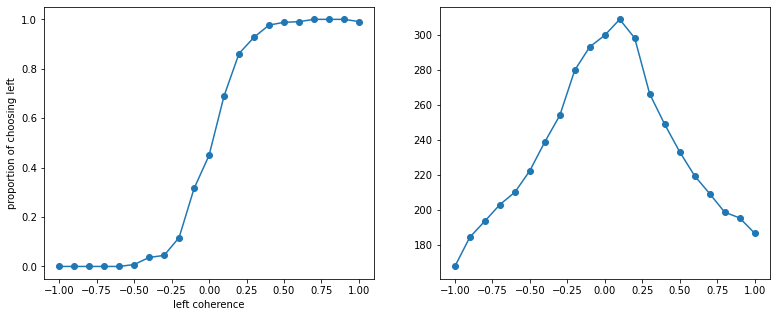

In [18]:
# psychrometric curve 
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.scatter(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.xlabel("left coherence")
plt.ylabel("proportion of choosing left")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



# RT within same coherence

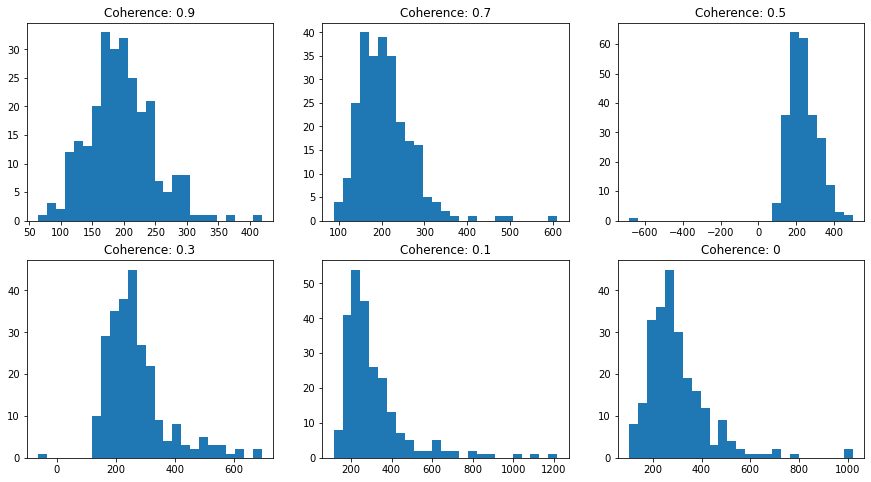

In [19]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# Check the activity of each recurrent unit

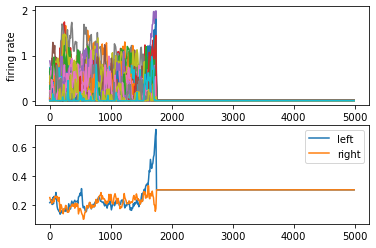

In [20]:
trial_num = 50
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()

In [21]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("./resultData/gainM20230809.mat", mdic)

In [18]:
model.destruct()